Starting training...
Epoch 1/50 - Train Loss: 76.4211 - Val Loss: 24.4603
Epoch 2/50 - Train Loss: 20.0219 - Val Loss: 8.9239
Epoch 3/50 - Train Loss: 10.0449 - Val Loss: 5.1213
Epoch 4/50 - Train Loss: 8.3598 - Val Loss: 4.6851
Epoch 5/50 - Train Loss: 8.0540 - Val Loss: 4.5470
Epoch 6/50 - Train Loss: 7.8440 - Val Loss: 4.3703
Epoch 7/50 - Train Loss: 7.6480 - Val Loss: 4.3752
Epoch 8/50 - Train Loss: 7.2209 - Val Loss: 4.2349
Epoch 9/50 - Train Loss: 7.0812 - Val Loss: 4.1816
Epoch 10/50 - Train Loss: 7.0127 - Val Loss: 4.3021
Epoch 11/50 - Train Loss: 7.2021 - Val Loss: 4.1850
Epoch 12/50 - Train Loss: 7.0197 - Val Loss: 4.0573
Epoch 13/50 - Train Loss: 6.9086 - Val Loss: 4.0736
Epoch 14/50 - Train Loss: 6.5891 - Val Loss: 4.0387
Epoch 15/50 - Train Loss: 6.8147 - Val Loss: 4.0645
Epoch 16/50 - Train Loss: 6.9802 - Val Loss: 4.0106
Epoch 17/50 - Train Loss: 6.7618 - Val Loss: 4.1759
Epoch 18/50 - Train Loss: 6.7061 - Val Loss: 4.1199
Epoch 19/50 - Train Loss: 7.0094 - Val Loss: 4.0

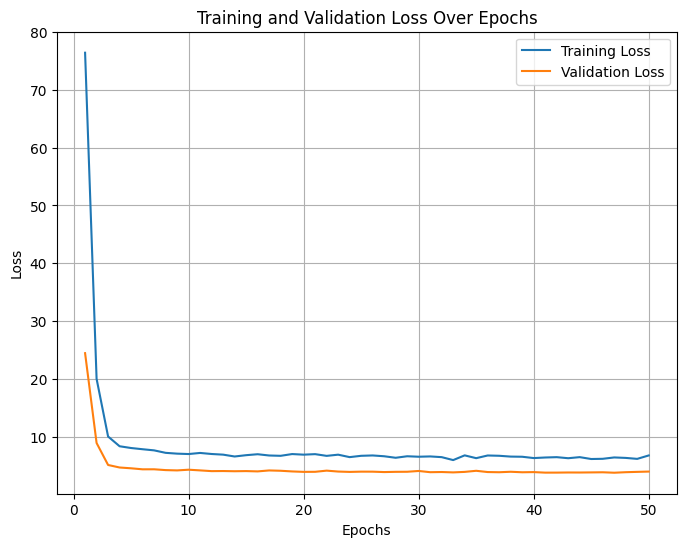

Training completed. Best model saved as best_model.pt
Test predictions saved to test_with_predictions.csv


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# -------------------------------
# Custom Dataset Class
# -------------------------------
class AbaloneDataset(Dataset):
    def __init__(self, data, targets=None):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        features = self.data.iloc[idx].values.astype(np.float32)
        if self.targets is not None:
            target = np.array(self.targets.iloc[idx]).astype(np.float32)
            return torch.tensor(features), torch.tensor(target)
        else:
            return torch.tensor(features)

# -------------------------------
# Neural Network Model Definition
# -------------------------------
class AbaloneNet(nn.Module):
    def __init__(self, input_dim):
        super(AbaloneNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.model(x)

# -------------------------------
# Preprocessing Function
# -------------------------------
def preprocess_data(df, scaler=None, is_train=True):
    df_encoded = pd.get_dummies(df, columns=["Sex"])
    for col in ['Sex_F', 'Sex_I', 'Sex_M']:
        if col not in df_encoded.columns:
            df_encoded[col] = 0
    continuous_cols = ["Length", "Diameter", "Height", "Whole_weight",
                       "Shucked_weight", "Viscera_weight", "Shell_weight"]
    if is_train:
        scaler = StandardScaler()
        df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided for test data preprocessing.")
        df_encoded[continuous_cols] = scaler.transform(df_encoded[continuous_cols])
    return df_encoded, scaler

# -------------------------------
# Training Function with Loss Plot
# -------------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, n_epochs=50, device='cpu'):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for features, target in train_loader:
            features = features.to(device)
            target = target.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * features.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, target in val_loader:
                features = features.to(device)
                target = target.to(device).view(-1, 1)
                outputs = model(features)
                loss = criterion(outputs, target)
                val_loss += loss.item() * features.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, "best_model.pt")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, n_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.savefig("loss_plot.png")
    plt.show()

    return model

# -------------------------------
# Main Execution Function
# -------------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_df = pd.read_csv("data/train.csv")
    train_features = train_df.drop(columns=["Rings"])
    train_targets = train_df["Rings"]
    train_features_processed, scaler = preprocess_data(train_features, is_train=True)
    
    processed_train_df = train_features_processed.copy()
    processed_train_df["Rings"] = train_targets.values
    train_data, val_data = train_test_split(processed_train_df, test_size=0.2, random_state=42)

    train_dataset = AbaloneDataset(train_data.drop(columns=["Rings"]), train_data["Rings"])
    val_dataset = AbaloneDataset(val_data.drop(columns=["Rings"]), val_data["Rings"])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    input_dim = train_data.drop(columns=["Rings"]).shape[1]
    model = AbaloneNet(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Starting training...")
    model = train_model(model, criterion, optimizer, train_loader, val_loader, n_epochs=50, device=device)
    print("Training completed. Best model saved as best_model.pt")

    test_df = pd.read_csv("data/test.csv")
    test_features_processed, _ = preprocess_data(test_df, scaler=scaler, is_train=False)
    
    test_dataset = AbaloneDataset(test_features_processed)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    best_model_state = torch.load("best_model.pt", map_location=device)
    model.load_state_dict(best_model_state)
    model.eval()

    predictions = []
    with torch.no_grad():
        for features in test_loader:
            features = features.to(device)
            outputs = model(features)
            predictions.extend(outputs.cpu().numpy().flatten().tolist())

    test_df["Rings"] = predictions
    test_df.to_csv("test_with_predictions.csv", index=False)
    print("Test predictions saved to test_with_predictions.csv")

if __name__ == "__main__":
    main()
